# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

In [8]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [9]:
display(geo_data_0.head())
display(geo_data_1.head())
display(geo_data_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Видно что масштаб данных различен, нужно их выровнить перед анализом

In [10]:
display(geo_data_0.info())
display(geo_data_1.info())
display(geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропусков нет

In [11]:
display(geo_data_0.describe())
display(geo_data_1.describe())
display(geo_data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Медиана почти ровна средней вовсех фреймах, значит выбросов нет

Рассмотрим корреляцию признаков

<AxesSubplot:>

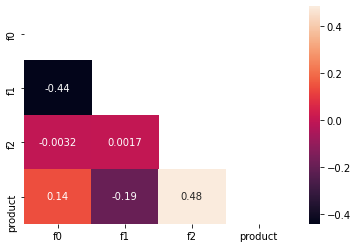

In [12]:
matrix = np.triu(geo_data_0.corr())
sns.heatmap(geo_data_0.corr(),annot = True, mask=matrix)

<AxesSubplot:>

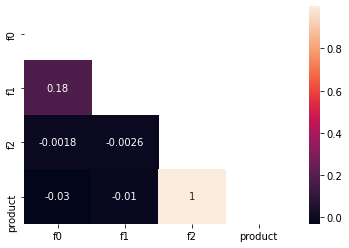

In [13]:
matrix = np.triu(geo_data_1.corr())
sns.heatmap(geo_data_1.corr(),annot = True, mask=matrix)

<AxesSubplot:>

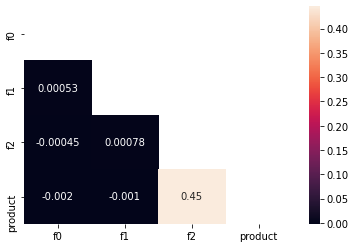

In [14]:
matrix = np.triu(geo_data_2.corr())
sns.heatmap(geo_data_2.corr(),annot = True, mask=matrix)

Видно что корреляции между признаками нет, есть прямая зависимость во втором регионе от признака f2, это значит что во втором регионе количество добычи напрямую зависит от признака f2

Для задачи столбцы с id нам не нужны удалим их.

In [15]:
geo_data_0 = geo_data_0.drop('id', axis=1)
geo_data_1 = geo_data_1.drop('id', axis=1)
geo_data_2 = geo_data_2.drop('id', axis=1)

In [16]:
geo_data_0.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


## Обучение и проверка модели

In [17]:
#функция обработки данных
def prepare (geo_data_reg):
    features = geo_data_reg.drop('product',axis=1)
    target = geo_data_reg['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
    
                                                                                  test_size=0.25, random_state = 12345)
    #масштабирование
    numeric = ['f0','f1','f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid, target_train, target_valid

In [18]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = prepare(geo_data_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = prepare(geo_data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = prepare(geo_data_2)

In [19]:
#проверка функции
print(features_train_0.shape)
print(features_valid_0.shape)
print(target_train_0.shape)
print(target_valid_0.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [20]:
features_train_0.describe() #проверка масштабирования

,f0,f1,f2
count,7.500000e+04,7.500000e+04,7.500000e+04
mean,1.680907e-16,-3.474554e-17,6.442254e-18
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-2.186288e+00,-2.178269e+00,-3.890945e+00
25%,-6.575544e-01,-8.925344e-01,-6.799576e-01
50%,1.878842e-03,-7.407961e-04,4.288679e-03
75%,6.571176e-01,8.928514e-01,6.829752e-01
max,2.139081e+00,2.169192e+00,4.153623e+00


In [21]:
# функция для получения результатов моделирования
def modeling(features_train, features_valid, target_train, target_valid):
    
    model = LinearRegression() 
    model.fit(features_train, target_train) 
    predictions_valid = pd.Series(model.predict(features_valid)) 

    rmse = mean_squared_error(target_valid, predictions_valid)**0.5 # считаем значение метрики RMSE
    mean_pred_pr = predictions_valid.mean()
    
    return predictions_valid, rmse, mean_pred_pr

In [22]:
# данные по всем регионам
predictions_valid_0, rmse_0, mean_pred_pr_0 = modeling(features_train_0, features_valid_0, target_train_0, target_valid_0)
predictions_valid_1, rmse_1, mean_pred_pr_1 = modeling(features_train_1, features_valid_1, target_train_1, target_valid_1)
predictions_valid_2, rmse_2, mean_pred_pr_2 = modeling(features_train_2, features_valid_2, target_train_2, target_valid_2)

print('Средний запас региона 1 предсказания равен {:.2f}, а RMSE {:.2f}'.format(mean_pred_pr_0, rmse_0))
print('Средний запас региона 2 предсказания равен {:.2f}, а RMSE {:.2f}'.format(mean_pred_pr_1, rmse_1))
print('Средний запас региона 3 предсказания равен {:.2f}, а RMSE {:.2f}'.format(mean_pred_pr_2, rmse_2))

Средний запас региона 1 предсказания равен 92.59, а RMSE 37.58
Средний запас региона 2 предсказания равен 68.73, а RMSE 0.89
Средний запас региона 3 предсказания равен 94.97, а RMSE 40.03


In [23]:
print('Истинный средний запас региона 1 равен {:.2f}'.format(target_valid_0.mean()))
print('Истинный средний запас региона 2 равен {:.2f}'.format(target_valid_1.mean()))
print('Истинный средний запас региона 3 равен {:.2f}'.format(target_valid_2.mean()))

Истинный средний запас региона 1 равен 92.08
Истинный средний запас региона 2 равен 68.72
Истинный средний запас региона 3 равен 94.88


#### Вывод:
1 Все три модели показывают верные предсказания, отличия не значительные от целевого признака.

2 Наилуший прогноз получили на второй моделе так как признак f2 имеет прямую зависимость с целевым признаком.

3 Модели 1 и 3 предсказывают примерно одинаков согласно RMSE


## Подготовка к расчёту прибыли

#### Ключевые переменные

In [24]:
explore_count = 500 #кол-во исследуемых точек
best_count = 200 #кол-во лучших точек
budget = 10000 #бюджет в млн
revenue_bar = 0.45 #доход с 1 единийы в 1000 бар
loss_probability = 0.025 #макс вероятность убытков
bootstrap = 1000 #количество выборок

<div class="alert alert-block alert-info">
    
<b>Совет:</b> Константы принято записывать в Верхнем регистре)
    

#### Расчет объема сырья для безубытка

In [25]:
budget_per_borehole = budget / best_count
product_volume = budget_per_borehole / revenue_bar

print('Объем сырья для безубыточной выработки 1 скважины в тыс. баррелей {:.2f}'.format(product_volume))

Объем сырья для безубыточной выработки 1 скважины в тыс. баррелей 111.11


Среднее значение выроботки со скважин менее необходимого минимума для безубытка, по этому нельзя выбрат скважины случайным образом.



#### Выбираем скважины с максимальными значениями предсказаний.

In [26]:
def max_profit(target_valid, predictions_valid):
    pred_choice = predictions_valid.sort_values(ascending=False).head(200) 
    target_choice = target_valid.reset_index(drop=True)[pred_choice.index] 
    income = target_choice.sum() * revenue_bar # доход в млн. рублей с 200 скважин
    return income

In [27]:
print('Прибыль в с 200 лучших по предсказаниям модели скважин составит:')
print('для региона 1 - {:.2f} млн. руб.'.format(max_profit(target_valid_0, predictions_valid_0) - budget))
print('для региона 2 - {:.2f} млн. руб.'.format(max_profit(target_valid_1, predictions_valid_1) - budget))
print('для региона 3 - {:.2f} млн. руб.'.format(max_profit(target_valid_2, predictions_valid_2) - budget))

Прибыль в с 200 лучших по предсказаниям модели скважин составит:
для региона 1 - 3320.83 млн. руб.
для региона 2 - 2415.09 млн. руб.
для региона 3 - 2710.35 млн. руб.


Прибыль с лучших скважин получилась от 2.4 до 3.3 млрд. , но такие значения мы можем получить разведав все скважины, по этому будем брать 500 случайных указанных в ТЗ

## Расчёт прибыли и рисков 

In [28]:
def revenue (target_valid, predictions_valid, best_count):
    pred_choice = predictions_valid.sort_values(ascending=False) 
    
    
    target_choice = target_valid[pred_choice.index][:best_count]
    income = target_choice.sum() * revenue_bar 
    return income

In [29]:
def income_distribution (predictions_valid, target_valid, bootstrap, explore_count):
    state = np.random.RandomState(12345)
    
    count = 0 

    values = [] 
    
    for i in range(bootstrap): 
        target_subsample = target_valid.reset_index(drop=True).sample(explore_count, replace=True, random_state=state)
        probs_subsample = predictions_valid[target_subsample.index]
        rev = revenue(target_subsample, probs_subsample, best_count) - budget
        values.append(rev)
        
        if rev < 0:
            count +=1

    values = pd.Series(values)
    
    mean = values.mean()
    print("Средняя выручка: {:.2f} ".format(mean), 'млн. рублей')
    
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), np.std(values, ddof=1))
    print("95%-ый доверительный интервал:", confidence_interval)
    
    pvalue = 1. * count / bootstrap
    if pvalue < loss_probability:
        print("Вероятность убытков равна {:.2%} и меньше допустимой, регион подходит по критериям".format(pvalue))
    else:
        print("Вероятность убытков равна {:.2%} и больше допустимой, регион не подходит по критериям".format(pvalue))    
    
    plt.figure()
    _ = plt.hist(values,  bins=100)
    
    x_5, y_5 = [confidence_interval[0],confidence_interval[0]], [0, 30]
    x_95, y_95 = [confidence_interval[1],confidence_interval[1]], [0, 30]
    plt.title('Гистограмма распределения прибыли')
    plt.xlabel('Прибыль в млн. рублей')
    plt.plot(x_5, y_5, x_95, y_95)

Первый регион 500 случайных выборок
Средняя выручка: 425.94  млн. рублей
95%-ый доверительный интервал: (-118.17308158673279, 970.0501354079182)
Вероятность убытков равна 6.00% и больше допустимой, регион не подходит по критериям


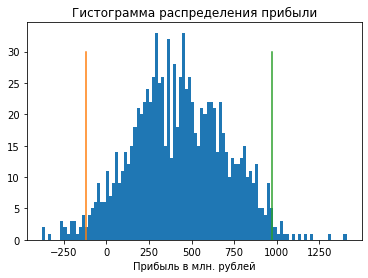

In [32]:
print('Первый регион 500 случайных выборок')
income_distribution (predictions_valid_0, target_valid_0, bootstrap, explore_count)

Второй регион 500 случайных выборок
Средняя выручка: 515.22  млн. рублей
95%-ый доверительный интервал: (85.11198847686433, 945.333558409716)
Вероятность убытков равна 1.00% и меньше допустимой, регион подходит по критериям


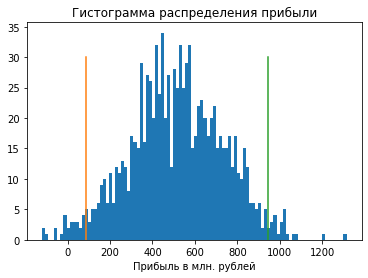

In [33]:
print('Второй регион 500 случайных выборок')
income_distribution (predictions_valid_1, target_valid_1, bootstrap, explore_count)

Второй регион 500 случайных выборок
Средняя выручка: 435.01  млн. рублей
95%-ый доверительный интервал: (-120.12349557730545, 990.1402211428172)
Вероятность убытков равна 6.40% и больше допустимой, регион не подходит по критериям


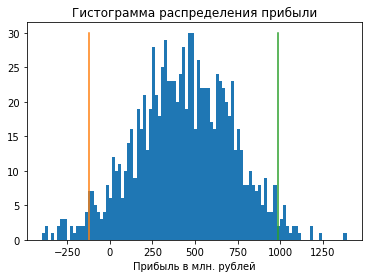

In [34]:
print('Второй регион 500 случайных выборок')
income_distribution (predictions_valid_2, target_valid_2, bootstrap, explore_count)

## Вывод
1. При случайном выборе 500 скважин потенцеальная прибыль падает. Рекомендуем заказчику пересмотреть бюджет на исследовние месторождений в большую сторону.

2. Все три региона являются потенциально прибыльными судя по средней выручке.

3. 1-й и 3-й регион имеют высокий процент вероятности убытков и по этому не подходят.

4. 2-й регион подходит под все критери  ТЗ, рекомендуется проводить дальнейшее освоении этого региона.